In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import nrrd
import json

In [2]:
# Define the folder containing the images
current_directory = os.getcwd()
print(os.getcwd())

C:\Users\prana\Desktop\CV_Project\Microscopy_Seg_CVProjectFall23


In [3]:
directory = current_directory + "\\tif\\"

Fast R-CNN is an evolution of the earlier R-CNN (Region-based Convolutional Neural Networks) and SPPnet (Spatial Pyramid Pooling in deep convolutional networks) models, designed for object detection tasks. Developed by Ross Girshick in 2015, Fast R-CNN improved upon its predecessors in terms of both speed and accuracy.

Functioning of Fast R-CNN:
Input and Feature Extraction:

Fast R-CNN takes an entire image and a set of object proposals as input.
The image is processed by a series of convolutional and max pooling layers to produce a convolutional feature map.


Region of Interest (RoI) Pooling:

For each object proposal, a Region of Interest (RoI) is defined on the feature map.
RoI pooling layer then extracts a fixed-size feature vector from each RoI (regardless of its size), ensuring consistent input size for the subsequent fully connected layers.


Classification and Bounding Box Regression:

These feature vectors are fed into a sequence of fully connected layers that finally branch into two output layers:
One for object classification (which includes a background class for negative samples).
The other for bounding box regression, which refines the positions of the proposed regions.
The classification layer outputs the probabilities of each RoI belonging to each object class.
The regression layer outputs bounding box adjustments for improving the accuracy of the proposed region.
Advantages of Fast R-CNN:
Efficiency: Unlike R-CNN which processes each object proposal independently, Fast R-CNN shares computation on the entire image, making it significantly faster.
Accuracy: It introduces a multi-task loss that combines classification and bounding box regression, leading to improvements in detection accuracy.


Applications:
Fast R-CNN, like other object detection models, is widely used in various applications such as:

Automated vehicle systems for detecting pedestrians, vehicles, and other objects.
Surveillance and security to identify activities and objects of interest.
Industrial automation for defect detection, quality control, and automated assembly.
Retail to automate checkout processes by recognizing products.
Wildlife monitoring for species identification and behavior study.
Limitations:
Despite its improvements, Fast R-CNN still relies on external region proposal algorithms like Selective Search, which can be a bottleneck.
The subsequent development of Faster R-CNN integrated region proposal networks (RPN) directly into the model, further improving both speed and accuracy, addressing one of the main limitations of Fast R-CNN.

In [324]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

In [411]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotations = []
        
                # Define the transform for normalization
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),  # Resize if required by your model
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform or transforms.ToTensor()

        # Load annotations
        annotation_files = glob.glob(os.path.join(annotation_folder, '*gt_*.json'))
        for annotation_file in annotation_files:
            with open(annotation_file) as f:
                annotations_data = json.load(f)
                img_name = os.path.basename(annotation_file).replace('gt_', '').replace('.json', '.tif')
                img_path = os.path.join(image_folder, img_name)
                if os.path.exists(img_path):
                    self.annotations.append({'image': img_name, 'bbox': annotations_data})

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['image'])
        image = tiff.imread(img_path)  # Use tifffile to read the image
        if image is None:
            print(f"Error loading image: {img_path}")
            return None
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)

        rois = []
        bbox = annotation['bbox']
        labels = []  # Assuming you have class labels for each bbox
        gt_boxes = []

        for bbox_data in bbox:
            if len(bbox_data) == 5:
                # If bbox format includes label
                x1, y1, x2, y2, label = bbox_data
            else:
                # If bbox format does not include label, use a default label, e.g., 0 or 1
                x1, y1, x2, y2 = bbox_data
                label = 1  # or 1, depending on your dataset

            labels.append(label)
            gt_boxes.append([x1, y1, x2, y2])

        # Convert to tensors and return
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        sample = {'image': image, 'bbox': gt_boxes_tensor, 'labels': labels_tensor}
        return sample

    def __len__(self):
        return len(self.annotations)

def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch if item is not None], dim=0)
    all_rois = []
    all_labels = []
    all_gt_boxes = []

    for batch_index, item in enumerate(batch):
        if item is not None:
            gt_boxes = item['bbox']
            labels = item['labels']
            for i, (gt_box, label) in enumerate(zip(gt_boxes, labels)):
                all_rois.append([batch_index] + gt_box.tolist())
                all_labels.append(label.item())
                all_gt_boxes.append(gt_box.tolist())

    return {
        'image': images, 
        'rois': torch.tensor(all_rois, dtype=torch.float32), 
        'labels': torch.tensor(all_labels, dtype=torch.int64), 
        'gt_boxes': torch.tensor(all_gt_boxes, dtype=torch.float32)
    }



from torch.utils.data.dataloader import default_collate

# When instantiating the dataset
train_dataset = CustomDataset(
    image_folder=os.path.join(directory, 'reTrain'),
    annotation_folder=os.path.join(directory, 'reTrainJS')
    # transform is None, will use the default one
)

test_dataset = CustomDataset(
    image_folder=os.path.join(directory, 'reTest'),
    annotation_folder=os.path.join(directory, 'reTestJS')
    # transform is None, will use the default one
)


# Then, create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [412]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops import RoIPool, nms

class FastRCNN(nn.Module):
    def __init__(self, num_classes):
        super(FastRCNN, self).__init__()
        self.num_classes = num_classes  # Store num_classes as an instance attribute

        # Load a pre-trained VGG16 model
        base_model = models.vgg16(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the last maxpool layer

        # RoI Pooling
        self.roi_pool = RoIPool(output_size=(7, 7), spatial_scale=1.0)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        # Bounding Box Regressor
        self.regressor = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes * 4)  # 4 coordinates for each class
        )

    def forward(self, images, rois):
        # Extract feature maps
        feature_maps = self.feature_extractor(images)

        # Convert rois to float tensor if it's not already
        if rois.dtype != torch.float32:
            rois = rois.to(dtype=torch.float32)

        # Apply RoI pooling
        pooled_features = self.roi_pool(feature_maps, rois)

        # Flatten the pooled features
        flattened_features = pooled_features.view(pooled_features.size(0), -1)

        # Classify and regress bounding boxes
        class_logits = self.classifier(flattened_features)
        
        # Correct handling of bbox deltas
        all_bbox_deltas = self.regressor(flattened_features)
        # Reshape to separate class-wise deltas
        bbox_deltas = all_bbox_deltas.view(-1, self.num_classes, 4)
        # Select bbox deltas for the class with the highest probability
        class_probs = torch.softmax(class_logits, dim=1)
        max_probs, max_indices = torch.max(class_probs, dim=1)
        selected_bbox_deltas = bbox_deltas[range(len(max_indices)), max_indices]

        return class_logits, selected_bbox_deltas

# Multi-task Loss
class FastRCNNLoss(nn.Module):
    def __init__(self):
        super(FastRCNNLoss, self).__init__()
        self.cls_loss = nn.CrossEntropyLoss()
        self.reg_loss = nn.SmoothL1Loss()

    def forward(self, class_logits, bbox_deltas, labels, gt_boxes):
        # Classification loss
        classification_loss = self.cls_loss(class_logits, labels)

        # Bounding box regression loss
        regression_loss = self.reg_loss(bbox_deltas, gt_boxes)

        # Combine losses
        total_loss = classification_loss + regression_loss
        return total_loss

# Non-Maximum Suppression
def apply_nms(class_logits, bbox_deltas, threshold=0.5):
    scores, classes = torch.max(class_logits, 1)
    keep = nms(bbox_deltas, scores, threshold)
    return bbox_deltas[keep], classes[keep], scores[keep]

# Instantiate the model and loss function
num_classes = 2  # Including background class
fast_rcnn_model1 = FastRCNN(num_classes)
fast_rcnn_loss_fn = FastRCNNLoss()

# Example usage
dummy_image = torch.randn(1, 3, 128, 128)
dummy_rois = torch.tensor([[0, 50, 50, 100, 100]])
dummy_labels = torch.tensor([1])
dummy_gt_boxes = torch.tensor([[50, 50, 100, 100]])

class_logits, bbox_deltas = fast_rcnn_model1(dummy_image, dummy_rois)
loss = fast_rcnn_loss_fn(class_logits, bbox_deltas, dummy_labels, dummy_gt_boxes)


# Apply NMS during inference
nms_boxes, nms_classes, nms_scores = apply_nms(class_logits, bbox_deltas)

print("Loss:", loss)
print("NMS Boxes:", nms_boxes)
print("NMS Classes:", nms_classes)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loss: tensor(75.1942, grad_fn=<AddBackward0>)
NMS Boxes: tensor([[ 0.0067, -0.0070, -0.0024, -0.0007]], grad_fn=<IndexBackward0>)
NMS Classes: tensor([0])


This is a basic implementation. You may need to adjust it based on your specific requirements, such as the backbone network, input image size, and the number of classes.
The rois input to the model should be the region proposals in the format [batch_idx, x1, y1, x2, y2]. You can use an external method to generate these proposals or implement an RPN.
The RoIPool layer requires a spatial scale factor (spatial_scale), which depends on the size of your feature maps relative to the original image size.
Training Fast R-CNN involves a more complex setup, including handling of region proposals, multitask loss for classification and regression, and potentially non-maximum suppression for inference.

**_____________________________________________________________________________________**


Non-Maximum Suppression (NMS) in Fast R-CNN:

Purpose:

In object detection tasks, especially with models like Fast R-CNN, the model often predicts multiple bounding boxes around the same object. These boxes may have varying sizes, positions, and confidence scores.
The purpose of NMS is to identify and retain only the best bounding box for each object while discarding the less accurate or redundant boxes.
How It Works:

NMS first looks at the list of all predicted bounding boxes and their associated confidence scores (how confident the model is that the box contains an object of interest).
It starts by selecting the box with the highest confidence score.
Then, it compares this box with all other boxes. If any other box has a significant overlap (determined by a parameter called the Intersection over Union or IoU threshold) with this box, it is considered redundant and removed.
This process is repeated, each time starting with the box with the next highest confidence score that hasn't been compared yet.
The process continues until all boxes have either been kept or discarded.
Why It's Used:

To reduce the number of false positives: Without NMS, you might end up with multiple boxes for the same object, making the output cluttered and less useful.
To improve accuracy: By keeping only the bounding boxes with the highest confidence scores and removing overlaps, NMS helps in making the final output more accurate and easier to interpret.
To streamline the detection process: It simplifies the output by ensuring that each detected object is represented by only one bounding box, making it easier to understand and process further.
Impact on Fast R-CNN:

In Fast R-CNN, NMS plays a crucial role in the post-processing stage. After the region proposal network (RPN) suggests potential object regions and the Fast R-CNN head predicts class scores and bounding box refinements, NMS is applied to filter these predictions.
The result is a cleaner, more precise set of bounding boxes that the model can use to accurately identify and locate objects within an image.

**____________________________________________________---**

In Fast R-CNN and similar object detection models, the performance and loss are influenced by several factors. Understanding these can help you optimize your model for better results. Here are some key aspects to consider:

Region of Interest (RoI) Generation:

In Fast R-CNN, RoIs are rectangular regions that potentially contain objects. These are fed into the network for classification and bounding box regression.
Initially, you're generating RoIs using a custom method based on your dataset annotations. This approach can work but might not be optimal.
Region Proposal Network (RPN): This is a part of the Faster R-CNN architecture. It's a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position. The RPN is trained end-to-end to generate high-quality region proposals.
Using a Pretrained RPN: Implementing an RPN or using a pretrained one (like from a pretrained Faster R-CNN model) can significantly improve the quality of region proposals, leading to better performance of the Fast R-CNN model.
Model Architecture and Parameters:

Backbone Network: The choice of the backbone network (like VGG16, ResNet, etc.) for feature extraction can significantly affect performance. Pretrained networks on large datasets (like ImageNet) often provide a good starting point.
Classifier and Regressor Layers: The architecture of the fully connected layers for classification and bounding box regression can be fine-tuned. More layers or neurons can capture complex patterns but might lead to overfitting.
Loss Function: The loss function in Fast R-CNN typically includes a classification loss (like CrossEntropyLoss) and a regression loss (like SmoothL1Loss). Balancing these two components is crucial for training stability and performance.
Training Hyperparameters:

Learning Rate: A proper learning rate is crucial. Too high can lead to divergence, too low might result in slow convergence.
Batch Size: Affects the gradient estimation. Larger batches provide more stable gradients but require more memory.
Optimizer: Different optimizers (like Adam, SGD) have different convergence properties.
Regularization: Techniques like dropout and weight decay (L2 regularization) can help prevent overfitting.
Data Quality and Augmentation:

The quality and diversity of the training data significantly influence model performance.
Data augmentation (like rotations, flipping, scaling) can improve the robustness and generalizability of the model.
Non-Maximum Suppression (NMS):

NMS is used during inference to eliminate redundant overlapping bounding boxes. It ensures that each object is detected only once.
The threshold for NMS can be tuned based on how much overlap you expect between bounding boxes for different objects.
Region Proposal Quality:

The quality of region proposals directly impacts the final detection performance. Better proposals mean the model can focus on learning finer classification and regression tasks.
Implementing or utilizing a pretrained RPN from a model like Faster R-CNN can significantly enhance the initial region proposals' quality, leading to overall better performance of your Fast R-CNN model. Additionally, fine-tuning the various aspects mentioned above can lead to a reduction in loss and improved detection accuracy.

In [413]:
import torch

num_classes = 2

# Instantiate the model
fast_rcnn_model1 = FastRCNN(num_classes)  # Assuming FastRCNN is your model class
fast_rcnn_model1.eval()  # Set the model to evaluation mode

# Create a dummy image (batch size, number of channels, height, width)
# Adjust the size according to your network's input requirements
dummy_image = torch.randn(1, 3, 224, 224)

# Create dummy RoIs (number of RoIs, 5 elements: batch_index, x1, y1, x2, y2)
# Here, we create one RoI for simplicity
dummy_rois = torch.tensor([[0, 50, 50, 100, 100]], dtype=torch.float32)

# Pass the dummy data through the model
with torch.no_grad():
    class_logits, bbox_deltas = fast_rcnn_model1(dummy_image, dummy_rois)

# Print the shapes of the outputs
print("Shape of class logits:", class_logits.shape)
print("Shape of bounding box deltas:", bbox_deltas.shape)


Shape of class logits: torch.Size([1, 2])
Shape of bounding box deltas: torch.Size([1, 4])


In [321]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118Note: you may need to restart the kernel to use updated packages.



In [414]:
import torch

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

# Instantiate the model
fast_rcnn_model1 = FastRCNN(num_classes=2)  # Include the number of classes
fast_rcnn_model1.to(device)  # Move the model to the device

# Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Optimizer
optimizer = torch.optim.Adam(fast_rcnn_model1.parameters(), lr=learning_rate)

def train_model(model, train_loader, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            rois = batch['rois'].to(device)  # RoIs for each image
            labels = batch['labels'].to(device)  # Class labels for each RoI
            gt_boxes = batch['gt_boxes'].to(device)  # Ground truth boxes for each RoI

            # Forward pass
            class_logits, bbox_deltas = model(images, rois)

            # Calculate loss
            loss = fast_rcnn_loss_fn(class_logits, bbox_deltas, labels, gt_boxes)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fast_rcnn_model1.to(device)
optimizer = torch.optim.Adam(fast_rcnn_model1.parameters(), lr=0.001)

train_model(fast_rcnn_model1, train_loader, optimizer, num_epochs=20, device=device)

Training on device: cpu
Epoch [1/20], Loss: 59.2755
Epoch [2/20], Loss: 31.9740
Epoch [3/20], Loss: 29.9037
Epoch [4/20], Loss: 29.5518
Epoch [5/20], Loss: 29.4988
Epoch [6/20], Loss: 29.4734
Epoch [7/20], Loss: 29.5245
Epoch [8/20], Loss: 29.4509
Epoch [9/20], Loss: 29.4802
Epoch [10/20], Loss: 29.5138
Epoch [11/20], Loss: 29.4160
Epoch [12/20], Loss: 29.4902
Epoch [13/20], Loss: 29.4564
Epoch [14/20], Loss: 29.5803
Epoch [15/20], Loss: 29.5532
Epoch [16/20], Loss: 29.5069
Epoch [17/20], Loss: 29.5162
Epoch [18/20], Loss: 29.5145
Epoch [19/20], Loss: 29.4999
Epoch [20/20], Loss: 29.5918


In [415]:
import torch
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    if isinstance(box1, (list, tuple, torch.Tensor)):
        x1, y1, x2, y2 = box1.tolist()
    else:
        x1, y1, x2, y2 = [box1, box1, box1, box1]

    if isinstance(box2, (list, tuple, torch.Tensor)):
        x1g, y1g, x2g, y2g = box2.tolist()
    else:
        x1g, y1g, x2g, y2g = [box2, box2, box2, box2]

    # Calculate intersection area
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou



def match_predictions_to_ground_truths(pred_boxes, pred_class, gt_boxes, labels, iou_threshold):
    """
    Match each predicted box to a ground truth box and update counts of TP, FP, FN.
    """
    matched_gt_indices = set()
    TP, FP = 0, 0

    for i in range(len(pred_boxes)):
        pred_box = pred_boxes[i]
        best_iou = 0
        best_gt_idx = -1
        for gt_idx in range(len(gt_boxes)):
            true_box = gt_boxes[gt_idx]
            iou = calculate_iou(pred_box, true_box)
            if iou > best_iou and labels[i] == pred_class:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_threshold and best_gt_idx not in matched_gt_indices:
            TP += 1
            matched_gt_indices.add(best_gt_idx)
        else:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt_indices)
    return TP, FP, FN



def evaluate_model(model, data_loader, device, iou_threshold=0.26):
    model.eval()
    TP, FP, FN = 0, 0, 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            rois = batch['rois'].to(device)
            labels = batch['labels'].to(device)
            gt_boxes = batch['gt_boxes'].to(device)

            class_logits, bbox_deltas = model(images, rois)

            # Apply NMS to get final predictions
            nms_boxes, nms_classes, _ = apply_nms(class_logits, bbox_deltas)

            for i in range(len(nms_classes)):
                pred_class = nms_classes[i].item()
                pred_box = nms_boxes[i].cpu().numpy()

                # Match predictions to ground truths
                tp, fp, fn = match_predictions_to_ground_truths(pred_box, pred_class, gt_boxes, labels, iou_threshold)
                TP += tp
                FP += fp
                FN += fn

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


In [418]:


iou_thresholds = np.linspace(0.3, 0.9, 5)  # Example IoU thresholds
precisions11 = []
recalls11 = []

for iou_thresh in iou_thresholds:
    precision, recall, _ = evaluate_model(fast_rcnn_model1, val_loader, device, iou_threshold=iou_thresh)
    precisions11.append(precision)
    recalls11.append(recall)
    
# Print the results
for i, threshold in enumerate(iou_thresholds):
    print(f"Threshold: {threshold:.2f}, Precision: {precisions11[i]:.4f}, Recall: {recalls11[i]:.4f}")



Threshold: 0.30, Precision: 0.0000, Recall: 0.0000
Threshold: 0.45, Precision: 0.0000, Recall: 0.0000
Threshold: 0.60, Precision: 0.0000, Recall: 0.0000
Threshold: 0.75, Precision: 0.0000, Recall: 0.0000
Threshold: 0.90, Precision: 0.0000, Recall: 0.0000


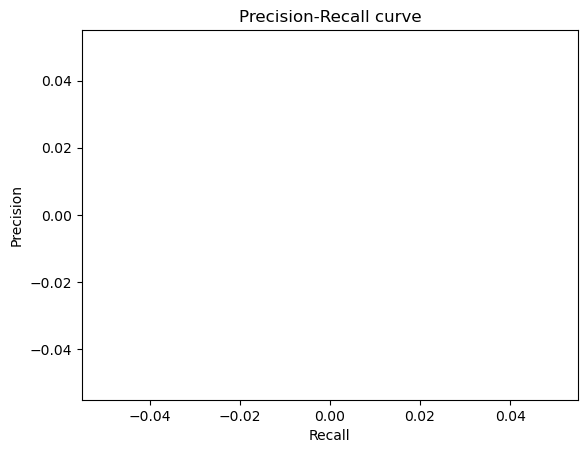

In [417]:

# Plotting Precision-Recall curve
plt.figure()
plt.plot(recalls11, precisions11, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


**Now implementing same model with pretrained RPNs**

1. Feature Pyramid Network (FPN) Benefits:
Multi-Scale Feature Representation: FPN enhances the backbone network (like ResNet) to create a pyramid of feature maps at different scales. This is particularly effective for detecting objects of various sizes, which is a common challenge in object detection.
Rich Semantic Information at All Levels: Unlike traditional convolutional backbones that might lose semantic information at higher levels (deeper layers), FPN maintains rich semantic information across all levels of the feature pyramid. This enhances the quality of the features used for both region proposal (by RPN) and object classification.
2. Pre-Trained RPN Benefits:
Efficient Region Proposals: The pre-trained RPN is optimized to propose candidate object regions (region proposals) efficiently. It is trained to distinguish between background and potential objects, making it a robust starting point for any object detection model.
Compatibility with FPN: When you use an RPN from a model like fasterrcnn_resnet50_fpn, it's already configured to work with multi-scale feature maps generated by the FPN. This ensures that the region proposals are informed by comprehensive feature representations at multiple scales.
3. Overall Model Enhancement:
Accuracy: By leveraging both FPN and a pre-trained RPN, the model can achieve higher accuracy, especially in detecting objects of various sizes and in complex scenes.
Speed and Efficiency: Despite the increased complexity, such models can be surprisingly efficient. The multi-scale approach of FPN reduces the need for processing images at multiple resolutions, and the pre-trained RPN can quickly generate high-quality region proposals.
Transfer Learning: Using components (like RPN) from pre-trained models allows leveraging knowledge from large datasets, which can be particularly beneficial when training data for the specific task is limited.
Why This Works Better Than Using RPN Alone:
RPN alone can propose regions, but it might not be as effective in handling the wide variety of object sizes and shapes encountered in real-world scenarios.
FPN integration ensures that the RPN has access to multi-scale, semantically rich features, improving its ability to propose regions that are more likely to contain objects.
The combination of FPN's rich feature representation and RPN's efficient proposal mechanism results in a more robust and versatile object detection framework.
In summary, this integrated approach takes advantage of the strengths of both FPN and RPN, leading to a more powerful and adaptable object detection model.

In [366]:
import torch
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import tifffile as tiff
import os
import cv2

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    normalize
])



class CustomDataset(Dataset):
    def __init__(self, image_folder, annotation_folder, transform=None):
        self.image_folder = image_folder
        self.annotations = []
        self.transform = transform or transforms.ToTensor()

        # Load annotations
        annotation_files = glob.glob(os.path.join(annotation_folder, '*gt_*.json'))
        for annotation_file in annotation_files:
            with open(annotation_file) as f:
                annotations_data = json.load(f)
                img_name = os.path.basename(annotation_file).replace('gt_', '').replace('.json', '.tif')
                img_path = os.path.join(image_folder, img_name)
                if os.path.exists(img_path):
                    self.annotations.append({'image': img_name, 'bbox': annotations_data})

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_path = os.path.join(self.image_folder, annotation['image'])
        image = tiff.imread(img_path)  # Use tifffile to read the image
        if image is None:
            print(f"Error loading image: {img_path}")
            return None
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if not isinstance(image, torch.Tensor):
            image = self.transform(image)

        rois = []
        bbox = annotation['bbox']
        labels = []  # Assuming you have class labels for each bbox
        gt_boxes = []

        for bbox_data in bbox:
            x1, y1, x2, y2 = bbox_data[:4]
            label = 1  # Assigning class 1 for all actual bounding boxes
            gt_boxes.append([x1, y1, x2, y2])
            labels.append(label)

        # Convert to tensors and return
        labels_tensor = torch.tensor(labels, dtype=torch.int64)
        gt_boxes_tensor = torch.tensor(gt_boxes, dtype=torch.float32)
        sample = {'image': image, 'bbox': gt_boxes_tensor, 'labels': labels_tensor}
        
        
        return sample

    def __len__(self):
        return len(self.annotations)

def collate_fn(batch):
    images = []
    targets = []
    
    for item in batch:
        if item is not None:
            images.append(item['image'])
            targets.append({'boxes': item['bbox'], 'labels': item['labels']})
            
    return images, targets


from torch.utils.data.dataloader import default_collate

# Load dataset
train_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTrain'), 
                              annotation_folder=os.path.join(directory, 'reTrainJS'), 
                              transform=transform)
test_dataset = CustomDataset(image_folder=os.path.join(directory, 'reTest'), 
                              annotation_folder=os.path.join(directory, 'reTestJS'), 
                              transform=transform)


# Then, create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


In [316]:
np.unique(labels)

array([0], dtype=int64)

In [346]:
print(torch.cuda.is_available())

False


In [317]:
import torch
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

class FastRCNNFPN(nn.Module):
    def __init__(self, num_classes):
        super(FastRCNNFPN, self).__init__()
        # Load a pre-trained Faster R-CNN model with FPN
        self.model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # Replace the classifier and box predictor of the ROI heads
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    def forward(self, images, targets=None):
        # The Faster R-CNN model with FPN handles feature extraction and RPN internally
        return self.model(images, targets)

# Instantiate the model
num_classes = 2  # Including background class
fast_rcnn_model = FastRCNNFPN(num_classes)

# Assuming your model is named `fast_rcnn_model` and it's already moved to the appropriate device
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=0.001)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In your training code, the loss is calculated by the fasterrcnn_resnet50_fpn model, which is a pre-built model from the torchvision.models.detection module. This model is designed to handle both the calculation of predictions and the computation of loss internally when provided with ground truth data during training.

In [326]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
fast_rcnn_model = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(fast_rcnn_model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 2

# Training loop
for epoch in range(num_epochs):
    fast_rcnn_model.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = fast_rcnn_model(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/2, Total Loss: 67.54901397228241
Epoch 2/2, Total Loss: 29.958325386047363


    Epoch 1/60, Total Loss: 106.14673352241516
    Epoch 2/60, Total Loss: 61.420443654060364
    Epoch 3/60, Total Loss: 48.06357991695404
    Epoch 4/60, Total Loss: 38.60013830661774
    Epoch 5/60, Total Loss: 31.02065360546112
    Epoch 6/60, Total Loss: 25.95257079601288
    Epoch 7/60, Total Loss: 21.401870399713516
    Epoch 8/60, Total Loss: 19.94567561149597
    Epoch 9/60, Total Loss: 19.29518312215805
    Epoch 10/60, Total Loss: 16.493781179189682
    Epoch 11/60, Total Loss: 14.82915860414505
    Epoch 12/60, Total Loss: 15.939875215291977
    Epoch 13/60, Total Loss: 16.367707759141922
    Epoch 14/60, Total Loss: 13.329490527510643
    Epoch 15/60, Total Loss: 12.859384953975677
    Epoch 16/60, Total Loss: 13.116562947630882
    Epoch 17/60, Total Loss: 19.988759756088257
    Epoch 18/60, Total Loss: 13.550785571336746
    Epoch 19/60, Total Loss: 12.04516439139843
    Epoch 20/60, Total Loss: 11.955163404345512
    Epoch 21/60, Total Loss: 11.241759791970253
    Epoch 22/60, Total Loss: 10.892927542328835
    Epoch 23/60, Total Loss: 9.424327775835991
    Epoch 24/60, Total Loss: 8.904954239726067
    Epoch 25/60, Total Loss: 9.280174598097801
    Epoch 26/60, Total Loss: 8.64730717241764
    Epoch 27/60, Total Loss: 8.551953986287117
    Epoch 28/60, Total Loss: 8.15172429382801
    Epoch 29/60, Total Loss: 9.699949577450752
    Epoch 30/60, Total Loss: 9.420573890209198
    Epoch 31/60, Total Loss: 8.100986912846565
    Epoch 32/60, Total Loss: 7.701948300004005
    Epoch 33/60, Total Loss: 7.6775273978710175
    Epoch 34/60, Total Loss: 7.542975574731827
    Epoch 35/60, Total Loss: 7.5395894050598145
    Epoch 36/60, Total Loss: 6.863753043115139
    Epoch 37/60, Total Loss: 6.995905347168446
    Epoch 38/60, Total Loss: 7.435594230890274
    Epoch 39/60, Total Loss: 6.872529454529285
    Epoch 40/60, Total Loss: 13.799871921539307
    Epoch 41/60, Total Loss: 9.949551969766617
    Epoch 42/60, Total Loss: 8.267889395356178
    Epoch 43/60, Total Loss: 7.17165943980217
    Epoch 44/60, Total Loss: 7.386036619544029
    Epoch 45/60, Total Loss: 7.896187469363213
    Epoch 46/60, Total Loss: 18.952034920454025
    Epoch 47/60, Total Loss: 11.544611781835556
    Epoch 48/60, Total Loss: 10.516193300485611
    Epoch 49/60, Total Loss: 8.037027418613434
    Epoch 50/60, Total Loss: 6.821349605917931
    Epoch 51/60, Total Loss: 6.671145610511303
    Epoch 52/60, Total Loss: 6.122318729758263
    Epoch 53/60, Total Loss: 6.080448232591152
    Epoch 54/60, Total Loss: 6.235117189586163
    Epoch 55/60, Total Loss: 5.995987877249718
    Epoch 56/60, Total Loss: 5.309894002974033
    Epoch 57/60, Total Loss: 5.426364719867706
    Epoch 58/60, Total Loss: 5.200811423361301
    Epoch 59/60, Total Loss: 4.842319451272488
    Epoch 60/60, Total Loss: 4.853198207914829
#These models were trained on a different system with GPU. We trained and saved the model. Which is then loaded here. The models were trained on this same code as this file

In [339]:
def load_model(model, load_path, device=torch.device('cpu')):
    # Ensure the model architecture is the same as the saved state_dict
    model.load_state_dict(torch.load(load_path, map_location=device))
    model.to(device)
    return model

# Usage example:
model_load_path = directory + 'fast_rcnn_resnet_model.pth'
fast_rcnn_model = FastRCNNFPN(num_classes)  # Replace with the appropriate number of classes
fast_rcnn_model = load_model(fast_rcnn_model, model_load_path, device)


Image 1 Predictions (before threshold):
Boxes: tensor([[ 59.6505,  49.8882,  73.4413,  62.8426],
        [ 79.5905,  84.3943,  88.3969,  96.2530],
        [114.6001,  97.3260, 125.5166, 116.1076],
        [ 69.1524,   8.7131,  80.0005,  19.3247],
        [102.6279,  89.6516, 110.0587, 100.7923],
        [ 91.6482,  37.2996, 100.4482,  49.3337],
        [  1.5605,  32.9122,  14.5565,  71.9468],
        [ 96.1456,  23.9142, 104.2260,  32.5442],
        [ 99.6849, 103.2160, 105.9580, 110.5166]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
Scores: tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9994, 0.9980, 0.9935])
Image 1 Predictions (after threshold):
Box 0: tensor([59.6505, 49.8882, 73.4413, 62.8426]), Score: 0.9998934268951416
Box 1: tensor([79.5905, 84.3943, 88.3969, 96.2530]), Score: 0.9998916387557983
Box 2: tensor([114.6001,  97.3260, 125.5166, 116.1076]), Score: 0.9998830556869507
Box 3: tensor([69.1524,  8.7131, 80.0005, 19.3247]), Score: 0.9998445510864258
Box 4: ten

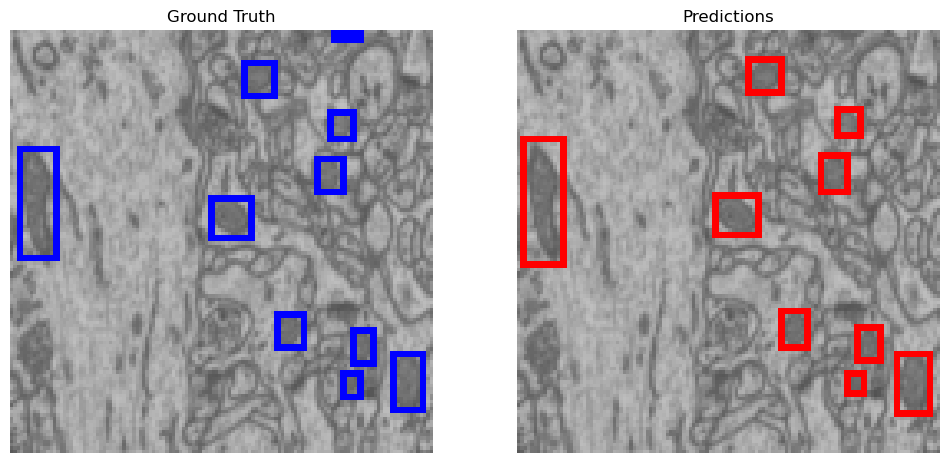

Image 2 Predictions (before threshold):
Boxes: tensor([[ 78.3435,  91.4657,  91.6677, 110.0446],
        [ 27.1454,  15.6257,  41.6327,  28.6560],
        [ 83.0383,  58.8185,  93.5789,  69.7647],
        [ 98.4487,  48.9920, 105.8789,  58.1001],
        [ 75.6135,  14.0724,  93.8754,  33.5155],
        [109.1381, 121.5879, 117.7965, 128.0000],
        [ 50.4225, 109.9886,  59.1488, 118.8602],
        [ 98.5302, 110.5709, 105.6196, 119.4132],
        [ 19.3739,  31.6468,  37.4339,  47.9066],
        [  7.7402, 105.9246,  18.4514, 128.0000],
        [117.4286,  68.1834, 125.7572,  78.5994],
        [  0.0000,  11.7272,  12.6755,  27.5884],
        [ 64.4239, 122.2603,  80.6743, 128.0000],
        [ 50.0562,  42.0993,  56.4761,  49.3312],
        [ 31.9254,  88.7534,  47.0303,  99.3328],
        [ 11.1101,  60.8248,  19.0344,  70.1086],
        [ 25.1252,  57.9559,  36.5797,  71.4184],
        [109.3387,   2.1132, 119.6325,  12.0538],
        [ 34.8270,   0.0000,  50.8338,   7.2351]])
La

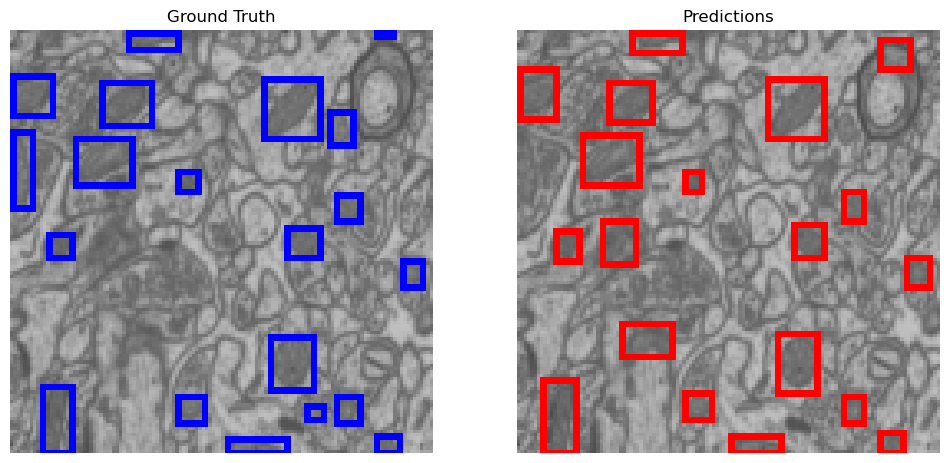

In [340]:
@torch.no_grad()
def evaluate_and_plot(model, data_loader, device, num_images=2, threshold=0.26):
    model.eval()
    images, targets = next(iter(data_loader))
    images = list(img.to(device) for img in images)
    predictions = model(images)

    for i in range(num_images):
        # Print predictions before thresholding
        print(f"Image {i+1} Predictions (before threshold):")
        prediction = predictions[i]
        print("Boxes:", prediction['boxes'])
        print("Labels:", prediction['labels'])
        print("Scores:", prediction['scores'])

        image = images[i].cpu()
        # If the image was normalized, we need to reverse the process
        if image.dtype == torch.float32:
            # Assuming that normalization was applied, these are the common mean and std values
            mean = torch.tensor([0.485, 0.456, 0.406])
            std = torch.tensor([0.229, 0.224, 0.225])
            image = image * std[:, None, None] + mean[:, None, None]
            image = torch.clamp(image, 0, 1)
            image = (image * 255).type(torch.uint8)

        target = targets[i]
        prediction = predictions[i]

        # Apply threshold
        pred_boxes = prediction['boxes'][prediction['scores'] > threshold]
        pred_scores = prediction['scores'][prediction['scores'] > threshold]

        # Draw ground truth and prediction boxes
        image_with_gt = draw_bounding_boxes(image, target['boxes'].cpu(), colors="blue", width=2)
        image_with_pred = draw_bounding_boxes(image, pred_boxes.cpu(), colors="red", width=2)

        # Print out the filtered predictions
        print(f"Image {i+1} Predictions (after threshold):")
        for j, (box, score) in enumerate(zip(pred_boxes, pred_scores)):
            print(f"Box {j}: {box.cpu()}, Score: {score.cpu()}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image_with_gt.permute(1, 2, 0).numpy())
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_with_pred.permute(1, 2, 0).numpy())
        plt.title('Predictions')
        plt.axis('off')

        plt.show()

# Call the function to evaluate and plot predictions
evaluate_and_plot(fast_rcnn_model, val_loader, device, num_images=2)


In [341]:
import torch
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Calculate intersection area
    xi1, yi1 = max(x1, x1g), max(y1, y1g)
    xi2, yi2 = min(x2, x2g), min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou

def match_predictions_to_ground_truths(pred_boxes, true_boxes, iou_threshold):
    """
    Match each predicted box to a ground truth box and update counts of TP, FP, FN.
    """
    matched_gt_indices = set()
    TP, FP = 0, 0

    for pred_box in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for gt_idx, true_box in enumerate(true_boxes):
            iou = calculate_iou(pred_box, true_box)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = gt_idx

        if best_iou >= iou_threshold and best_gt_idx not in matched_gt_indices:
            TP += 1
            matched_gt_indices.add(best_gt_idx)
        else:
            FP += 1

    FN = len(true_boxes) - len(matched_gt_indices)
    return TP, FP, FN


def evaluate_model(model, data_loader, device, iou_threshold=0.26):
    model.eval()
    TP, FP, FN = 0, 0, 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                true_boxes = targets[i]['boxes'].cpu().numpy()

                tp, fp, fn = match_predictions_to_ground_truths(pred_boxes, true_boxes, iou_threshold)
                TP += tp
                FP += fp
                FN += fn

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


Threshold: 0.30, Precision: 0.8713, Recall: 0.8558
Threshold: 0.42, Precision: 0.8616, Recall: 0.8463
Threshold: 0.55, Precision: 0.8359, Recall: 0.8210
Threshold: 0.68, Precision: 0.7707, Recall: 0.7570
Threshold: 0.80, Precision: 0.5346, Recall: 0.5251


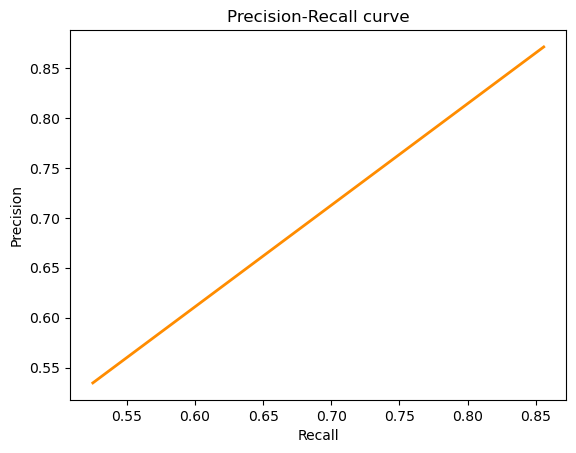

In [367]:
iou_thresholds = np.linspace(0.3, 0.8, 5)  # Example IoU thresholds
precisions1 = []
recalls1 = []

for iou_thresh in iou_thresholds:
    precision, recall, _ = evaluate_model(fast_rcnn_model, val_loader, device, iou_threshold=iou_thresh)
    precisions1.append(precision)
    recalls1.append(recall)
    
# Print the results
for i, threshold in enumerate(iou_thresholds):
    print(f"Threshold: {threshold:.2f}, Precision: {precisions1[i]:.4f}, Recall: {recalls1[i]:.4f}")


# Plotting Precision-Recall curve
plt.figure()
plt.plot(recalls1, precisions1, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


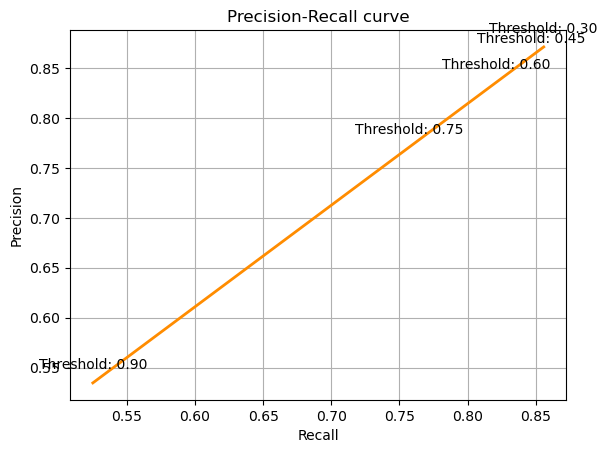

In [419]:
# Plotting Precision-Recall curve with threshold annotations
plt.figure()
plt.plot(recalls1, precisions1, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.grid(True)  # Add grid lines for reference

# Annotate points with threshold values
for i, threshold in enumerate(iou_thresholds):
    plt.annotate(f'Threshold: {threshold:.2f}', (recalls1[i], precisions1[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [356]:
from sklearn.metrics import auc

# Calculate the AP as the area under the PR curve
AP = auc(recalls1, precisions1)

# Find the best F1 score
f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions1, recalls1)]
max_f1_score = max(f1_scores)

print(f"Average Precision (AP): {AP}")
print(f"Best F1 Score: {max_f1_score}")

# Find the index of the maximum precision
max_precision_index = np.argmax(precisions1)

# Get the maximum precision and corresponding recall
max_precision = precisions1[max_precision_index]
corresponding_recall = recalls1[max_precision_index]

print(f"Best Precision: {max_precision}")
print(f"Corresponding Recall: {corresponding_recall}")

Average Precision (AP): 0.23246060991731493
Best F1 Score: 0.8634642216464024
Best Precision: 0.8712791633145616
Corresponding Recall: 0.8557882259976294


IoU Threshold: 0.2, Average IoU: 0.7860
IoU Threshold: 0.3, Average IoU: 0.7918
IoU Threshold: 0.4, Average IoU: 0.7996
IoU Threshold: 0.5, Average IoU: 0.8113
IoU Threshold: 0.6, Average IoU: 0.8215
IoU Threshold: 0.7, Average IoU: 0.8376
IoU Threshold: 0.8, Average IoU: 0.8681
IoU Threshold: 0.9, Average IoU: 0.9241


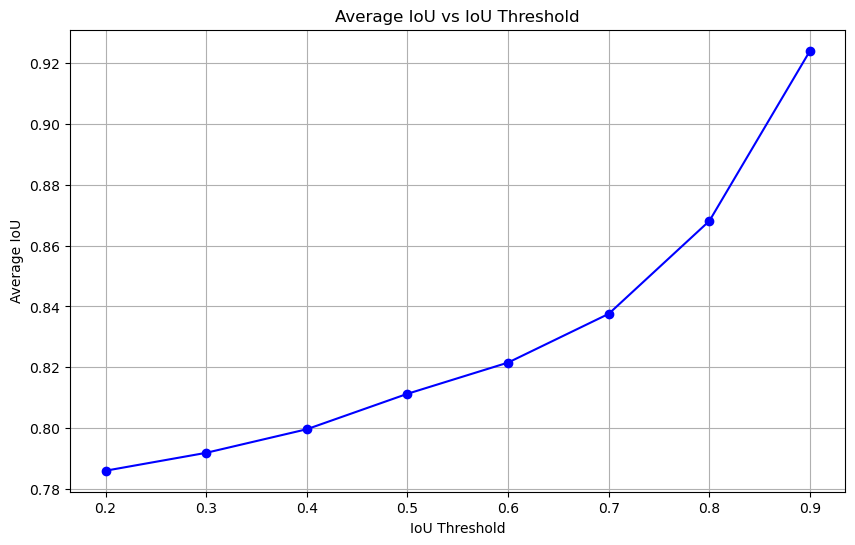

In [369]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def calculate_average_iou(model, data_loader, device, iou_threshold):
    model.eval()
    total_iou = 0
    total_matches = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                true_boxes = targets[i]['boxes'].cpu().numpy()

                for pred_box in pred_boxes:
                    best_iou = 0
                    for true_box in true_boxes:
                        iou = calculate_iou(pred_box, true_box)
                        if iou > best_iou:
                            best_iou = iou

                    if best_iou >= iou_threshold:
                        total_iou += best_iou
                        total_matches += 1

    average_iou = total_iou / total_matches if total_matches > 0 else 0
    return average_iou

# Evaluate the model at different IoU thresholds
iou_thresholds = np.arange(0.2, 1.0, 0.1)  # From 0.2 to 0.9
iou_scores = []

for iou_thresh in iou_thresholds:
    average_iou = calculate_average_iou(fast_rcnn_model, val_loader, device, iou_threshold=iou_thresh)
    iou_scores.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.1f}, Average IoU: {average_iou:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, iou_scores, marker='o', color='b')
plt.title("Average IoU vs IoU Threshold")
plt.xlabel("IoU Threshold")
plt.ylabel("Average IoU")
plt.grid(True)
plt.show()


In [385]:
for iou_thresh in additional_values:
    average_iou = calculate_average_iou(fast_rcnn_model, val_loader, device, iou_threshold=iou_thresh)
    #iou_scores.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.2f}, Average IoU: {average_iou:.4f}")

IoU Threshold: 0.95, Average IoU: 0.9602
IoU Threshold: 0.99, Average IoU: 0.0000


**# Now implementing different pretrained backbone for this fastR-CNN**

In [228]:
import torchvision.models as models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import mobilenet_backbone

def get_mobilenet_backbone(pretrained=True):
    backbone = mobilenet_backbone('mobilenet_v2', pretrained=pretrained, fpn=True)
    return backbone

# Create the FastRCNN model with a MobileNetV2 backbone
num_classes = 2  # Including background class
backbone = get_mobilenet_backbone(pretrained=True)
model_mobilenet = FasterRCNN(backbone, num_classes=num_classes)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [230]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
model_mobilenet = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model_mobilenet.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_mobilenet.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model_mobilenet(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/5, Total Loss: 50.233904272317886
Epoch 2/5, Total Loss: 8.266858369112015
Epoch 3/5, Total Loss: 6.2535132467746735
Epoch 4/5, Total Loss: 5.4232867658138275
Epoch 5/5, Total Loss: 5.071722164750099


Epoch 1/60, Total Loss: 64.10459727048874
Epoch 2/60, Total Loss: 43.7049426138401
Epoch 3/60, Total Loss: 53.152050256729126
Epoch 4/60, Total Loss: 43.70887899398804
Epoch 5/60, Total Loss: 35.37391394376755
Epoch 6/60, Total Loss: 26.87114578485489
Epoch 7/60, Total Loss: 27.147019803524017
Epoch 8/60, Total Loss: 22.12705025076866
Epoch 9/60, Total Loss: 18.755585253238678
Epoch 10/60, Total Loss: 17.637643933296204
Epoch 11/60, Total Loss: 18.29159277677536
Epoch 12/60, Total Loss: 20.24309867620468
Epoch 13/60, Total Loss: 21.612102031707764
Epoch 14/60, Total Loss: 17.84503448009491
Epoch 15/60, Total Loss: 15.006513625383377
Epoch 16/60, Total Loss: 13.885449379682541
Epoch 17/60, Total Loss: 13.052865624427795
Epoch 18/60, Total Loss: 12.791457206010818
Epoch 19/60, Total Loss: 12.199829310178757
Epoch 20/60, Total Loss: 11.921829625964165
Epoch 21/60, Total Loss: 13.069149255752563
Epoch 22/60, Total Loss: 11.639266416430473
Epoch 23/60, Total Loss: 10.304049372673035
Epoch 24/60, Total Loss: 10.094373852014542
Epoch 25/60, Total Loss: 10.068822413682938
Epoch 26/60, Total Loss: 10.410429313778877
Epoch 27/60, Total Loss: 9.321438193321228
Epoch 28/60, Total Loss: 9.224160432815552
Epoch 29/60, Total Loss: 8.655424490571022
Epoch 30/60, Total Loss: 8.916006371378899
Epoch 31/60, Total Loss: 8.497883260250092
Epoch 32/60, Total Loss: 8.277509465813637
Epoch 33/60, Total Loss: 7.656368359923363
Epoch 34/60, Total Loss: 8.378835946321487
Epoch 35/60, Total Loss: 7.538714453577995
Epoch 36/60, Total Loss: 8.1595089584589
Epoch 37/60, Total Loss: 7.887027099728584
Epoch 38/60, Total Loss: 8.118547692894936
Epoch 39/60, Total Loss: 7.214326918125153
Epoch 40/60, Total Loss: 7.70849546790123
Epoch 41/60, Total Loss: 7.62025648355484
Epoch 42/60, Total Loss: 7.162116914987564
Epoch 43/60, Total Loss: 6.965797439217567
Epoch 44/60, Total Loss: 6.808679401874542
Epoch 45/60, Total Loss: 6.133012302219868
Epoch 46/60, Total Loss: 5.915431015193462
Epoch 47/60, Total Loss: 6.1103368774056435
Epoch 48/60, Total Loss: 5.6809685081243515
Epoch 49/60, Total Loss: 9.39899991452694
Epoch 50/60, Total Loss: 10.442734718322754
Epoch 51/60, Total Loss: 7.89165535569191
Epoch 52/60, Total Loss: 7.240775972604752
Epoch 53/60, Total Loss: 6.884928673505783
Epoch 54/60, Total Loss: 6.128351904451847
Epoch 55/60, Total Loss: 5.6348279640078545


    Epoch 56/60, Total Loss: 8.682114958763123
    Epoch 57/60, Total Loss: 7.858552739024162
    Epoch 58/60, Total Loss: 6.7404842004179955
    Epoch 59/60, Total Loss: 5.803439170122147
    Epoch 60/60, Total Loss: 5.607960157096386
    

Image 1 Predictions (before threshold):
Boxes: tensor([[114.5567,  95.5785, 125.1779, 114.8694],
        [ 59.6748,  49.8788,  74.5532,  63.1488],
        [ 69.1089,   8.5907,  81.0195,  18.8116],
        [ 91.0131,  38.2156, 100.0539,  49.0741],
        [102.6806,  90.8263, 110.3936, 101.9829],
        [ 79.7483,  84.6911,  88.2181,  95.2252],
        [  0.1837,  30.8230,  13.3432,  66.3200],
        [ 96.0128,  23.8955, 104.1581,  32.1829],
        [100.2453, 103.1757, 105.8920, 108.8177],
        [  5.4379,  91.1216,  13.3240, 101.5138],
        [  2.1826,  44.3733,  12.2070,  66.8229]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Scores: tensor([0.9999, 0.9999, 0.9998, 0.9998, 0.9997, 0.9997, 0.9994, 0.9876, 0.9630,
        0.9457, 0.5776])
Image 1 Predictions (after threshold):
Box 0: tensor([114.5567,  95.5785, 125.1779, 114.8694]), Score: 0.9999396800994873
Box 1: tensor([59.6748, 49.8788, 74.5532, 63.1488]), Score: 0.9999014139175415
Box 2: tensor([69.1089,  8.5907, 81.01

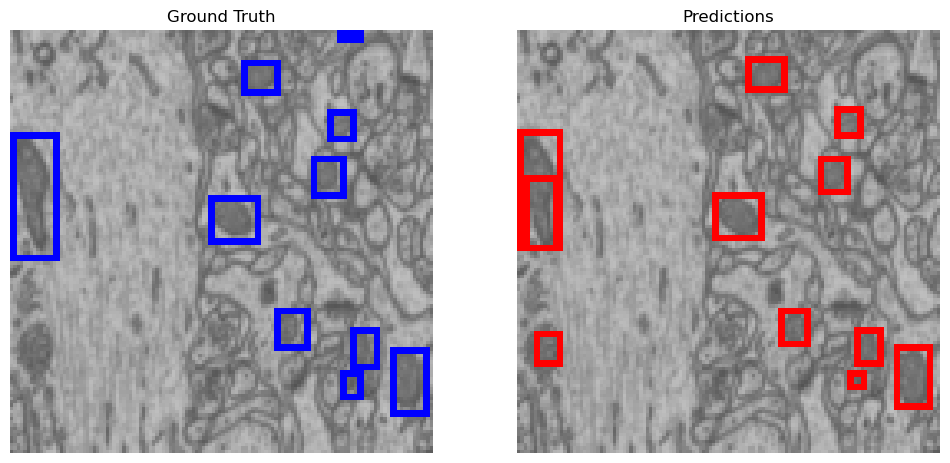

Image 2 Predictions (before threshold):
Boxes: tensor([[ 78.8134,  90.9693,  92.0467, 106.8822],
        [ 81.1827,   9.7299,  96.4146,  28.1317],
        [ 25.8106,  16.5465,  39.3277,  28.4223],
        [  6.8729, 114.0188,  16.0411, 128.0000],
        [ 81.7075,  56.6794,  90.9682,  66.3262],
        [ 98.1659,  47.0160, 105.6390,  57.0813],
        [117.4156,  65.8126, 126.2197,  76.8125],
        [ 23.8061,  30.7293,  37.0945,  42.6655],
        [ 99.2554, 107.5275, 107.0525, 117.4986],
        [ 50.9142, 107.9690,  60.6080, 116.4258],
        [111.4028,   2.9238, 122.7915,  15.3580],
        [ 41.1824,   0.0000,  60.6007,   7.4708],
        [ 20.2363,  42.5293,  30.7495,  54.4943],
        [  0.0000,  26.4812,  10.2947,  59.5891],
        [ 52.1032,  42.2996,  59.9881,  48.4803],
        [107.0156,  84.2094, 113.2370,  91.3175],
        [  2.1534,  12.8749,  13.3435,  21.8521],
        [ 21.2097,  28.4537,  35.2358,  54.1695]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

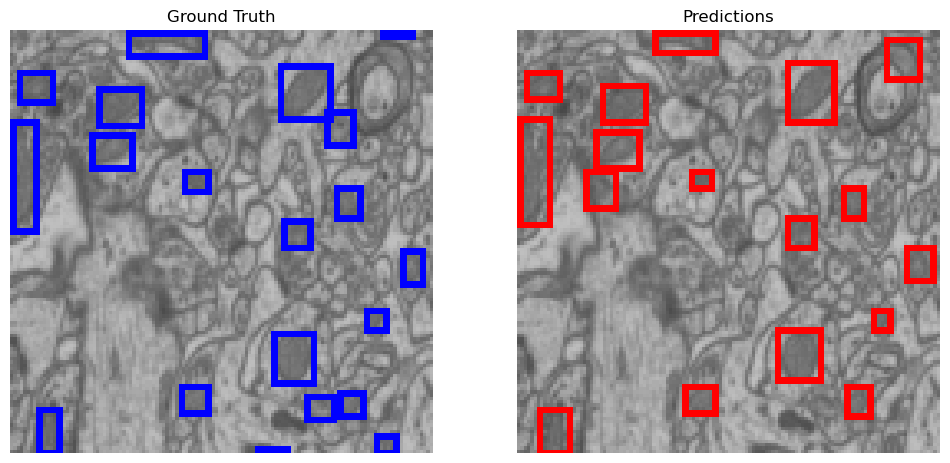

In [344]:
model_load_path = directory + 'fast_rcnn_mobilenet_model.pth'

model_mobilenet = load_model(model_mobilenet, model_load_path, device)

# Call the function to evaluate and plot predictions
evaluate_and_plot(model_mobilenet, val_loader, device, num_images=2)


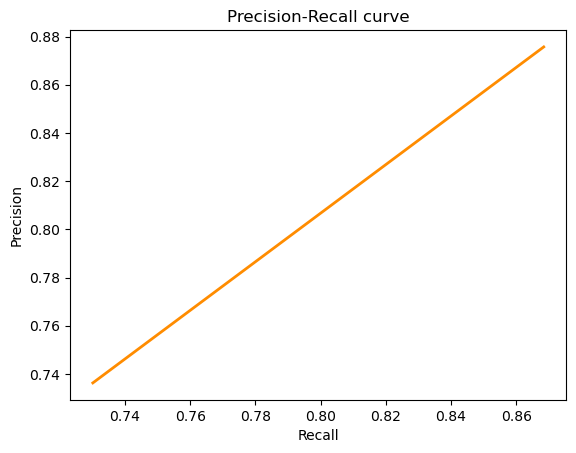

In [345]:
iou_thresholds = np.linspace(0.3, 0.8, 5)  # Example IoU thresholds
precisions = []
recalls = []

for iou_thresh in iou_thresholds:
    precision, recall, _ = evaluate_model(model_mobilenet, val_loader, device, iou_threshold=iou_thresh)
    precisions.append(precision)
    recalls.append(recall)

# Plotting Precision-Recall curve
plt.figure()
plt.plot(recalls, precisions, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


In [352]:
from sklearn.metrics import auc
import numpy as np
from sklearn.metrics import precision_recall_curve

# Calculate the AP as the area under the PR curve
AP = auc(recalls, precisions)

# Find the best F1 score
f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
max_f1_score = max(f1_scores)

print(f"Average Precision (AP): {AP}")
print(f"Best F1 Score: {max_f1_score}")


# Assuming `targets` and `predictions` are the ground truth and model output respectively
#precision, recall, thresholds = precision_recall_curve(targets, predictions)

# Find the index of the maximum precision
max_precision_index = np.argmax(precisions)

# Get the maximum precision and corresponding recall
max_precision = precisions[max_precision_index]
corresponding_recall = recalls[max_precision_index]

print(f"Best Precision: {max_precision}")
print(f"Corresponding Recall: {corresponding_recall}")


Average Precision (AP): 0.11145461614624085
Best F1 Score: 0.8720491965879785
Best Precision: 0.8756972111553785
Corresponding Recall: 0.8684314500197551


IoU Threshold: 0.2, Average IoU: 0.7766
IoU Threshold: 0.3, Average IoU: 0.7836
IoU Threshold: 0.4, Average IoU: 0.7977
IoU Threshold: 0.5, Average IoU: 0.8113
IoU Threshold: 0.6, Average IoU: 0.8212
IoU Threshold: 0.7, Average IoU: 0.8400
IoU Threshold: 0.8, Average IoU: 0.8728
IoU Threshold: 0.9, Average IoU: 0.9247


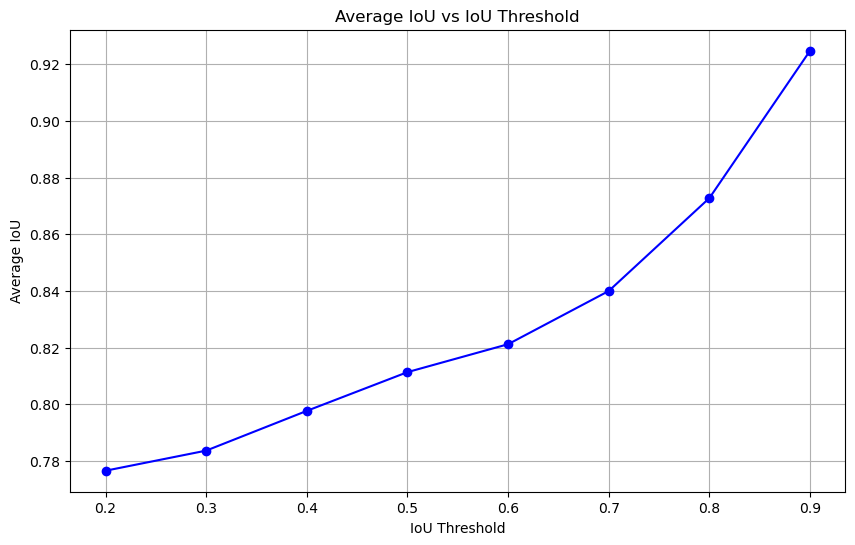

In [374]:
# Evaluate the model at different IoU thresholds
iou_thresholds = np.arange(0.2, 1.0, 0.1)  # From 0.2 to 0.9
iou_scores2 = []

for iou_thresh in iou_thresholds:
    average_iou = calculate_average_iou(model_mobilenet, val_loader, device, iou_threshold=iou_thresh)
    iou_scores2.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.1f}, Average IoU: {average_iou:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, iou_scores2, marker='o', color='b')
plt.title("Average IoU vs IoU Threshold")
plt.xlabel("IoU Threshold")
plt.ylabel("Average IoU")
plt.grid(True)
plt.show()

In [384]:
for iou_thresh in additional_values:
    average_iou = calculate_average_iou(model_mobilenet, val_loader, device, iou_threshold=iou_thresh)
    #iou_scores.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.2f}, Average IoU: {average_iou:.4f}")

IoU Threshold: 0.95, Average IoU: 0.9614
IoU Threshold: 0.99, Average IoU: 0.0000


In [229]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.models as models

def get_densenet_backbone(pretrained=True, backbone_name='densenet121'):
    # Load a pre-trained DenseNet model
    if backbone_name == 'densenet121':
        densenet_backbone = models.densenet121(pretrained=pretrained).features
    elif backbone_name == 'densenet169':
        densenet_backbone = models.densenet169(pretrained=pretrained).features
    # DenseNet uses `norm5` as its last layer, so we rename it.
    densenet_backbone.out_channels = 1024  # Adjust the number of output channels
    return densenet_backbone

# Create the FastRCNN model with a DenseNet backbone
num_classes = 2  # Including background class
backbone = get_densenet_backbone(pretrained=True, backbone_name='densenet121')
model_densenet = FasterRCNN(backbone, num_classes=num_classes)


C:\Users\prana\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\prana/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:00<00:00, 72.9MB/s]


In [231]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and move it to the device
num_classes = 2  # Including background class
model_densenet = FastRCNNFPN(num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model_densenet.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_densenet.train()  # Set the model to training mode
    epoch_loss = 0

    for images, targets in train_loader:
        # Prepare data for model
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model_densenet(images, targets)
        
        # Compute total loss
        total_loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Accumulate the loss for the epoch
        epoch_loss += total_loss.item()
    
    # Print the epoch's loss
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')


Epoch 1/5, Total Loss: 488.235453158617
Epoch 2/5, Total Loss: 105.02718013525009
Epoch 3/5, Total Loss: 9.05710881948471
Epoch 4/5, Total Loss: 8.124888628721237
Epoch 5/5, Total Loss: 7.736701428890228



    
Epoch 1/25, Total Loss: 120.23379933834076
Epoch 2/25, Total Loss: 63.01813316345215
Epoch 3/25, Total Loss: 50.39030683040619
Epoch 4/25, Total Loss: 41.12816256284714
Epoch 5/25, Total Loss: 34.749866008758545
Epoch 6/25, Total Loss: 31.169874250888824
Epoch 7/25, Total Loss: 25.45183002948761
Epoch 8/25, Total Loss: 22.24139702320099
Epoch 9/25, Total Loss: 20.140872210264206
Epoch 10/25, Total Loss: 20.872702032327652
Epoch 11/25, Total Loss: 18.37347486615181
Epoch 12/25, Total Loss: 16.711747229099274
Epoch 13/25, Total Loss: 16.138703227043152
Epoch 14/25, Total Loss: 15.128884077072144
Epoch 15/25, Total Loss: 13.945015698671341
Epoch 16/25, Total Loss: 13.463484272360802
Epoch 17/25, Total Loss: 12.975163638591766
Epoch 18/25, Total Loss: 12.978210270404816
Epoch 19/25, Total Loss: 11.893081679940224
Epoch 20/25, Total Loss: 11.070052176713943

    
    Epoch 21/25, Total Loss: 11.238416448235512
    Epoch 22/25, Total Loss: 10.3694227039814
    Epoch 23/25, Total Loss: 18.06568992137909
    Epoch 24/25, Total Loss: 16.018139019608498
    Epoch 25/25, Total Loss: 11.337757647037506

Image 1 Predictions (before threshold):
Boxes: tensor([[ 80.1842,  87.3915,  91.5141, 103.7234],
        [ 96.0425,  42.8622, 105.4712,  54.7471],
        [ 86.7169,   2.4310, 102.8980,  19.4675],
        [ 77.7427,   0.0000,  86.0941,  12.8202],
        [ 53.9699,  99.3850,  62.9590, 111.2194],
        [105.6794,  83.5785, 113.0042,  93.4919],
        [ 57.0165,  43.0844,  64.0901,  53.1905],
        [117.0924,  60.7779, 125.8220,  72.3380],
        [ 77.0352,  51.7180,  85.7915,  61.3347],
        [ 52.7383,   0.3730,  62.4316,  12.5054],
        [100.1584, 105.0488, 107.1072, 112.9801],
        [ 16.3157, 105.8295,  23.7459, 117.6698],
        [118.5891, 115.9245, 126.5126, 127.4917],
        [108.2239, 121.0982, 115.6535, 127.8648],
        [ 45.8823,  28.0362,  53.7355,  37.8289],
        [  9.6622, 125.6940,  13.4146, 127.9720],
        [125.0143,  72.2316, 128.0000,  78.2398],
        [125.2164,  70.9635, 128.0000,  83.5410],
        [ 85.0120,  27.8167,  91.1676,  33.4325],
   

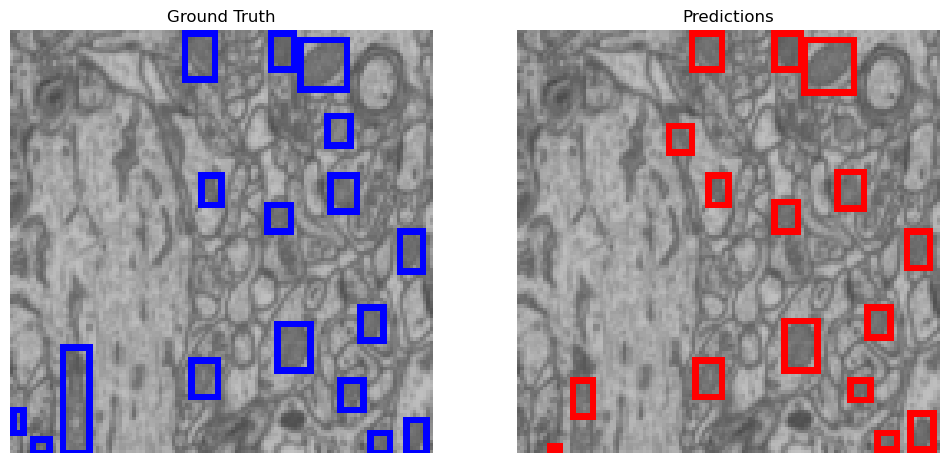

Image 2 Predictions (before threshold):
Boxes: tensor([[ 79.0687,  89.0198,  92.6090, 106.0612],
        [ 52.5024, 103.4132,  62.2463, 114.2024],
        [ 79.8906,  53.8706,  89.2358,  63.9268],
        [ 83.6573,   6.3875,  99.5645,  23.8743],
        [105.6063,  82.7718, 113.8235,  93.0434],
        [ 97.2715,  44.8774, 105.7623,  55.9049],
        [ 25.1713,  16.3229,  35.7988,  27.5066],
        [117.0324,  63.6052, 126.3980,  75.1578],
        [ 99.0955, 106.1519, 107.0325, 115.8855],
        [ 54.8592,  42.0299,  62.1546,  49.1986],
        [108.9667, 122.2467, 116.7595, 127.9899],
        [ 49.7196,   0.0000,  62.6286,  10.7017],
        [  0.0000,  41.0632,  12.8411,  62.1939],
        [  7.5494, 119.3045,  14.2678, 127.3045]])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Scores: tensor([0.9993, 0.9983, 0.9983, 0.9981, 0.9978, 0.9977, 0.9972, 0.9969, 0.9967,
        0.9967, 0.9922, 0.9916, 0.9519, 0.4186])
Image 2 Predictions (after threshold):
Box 0: tensor([ 7

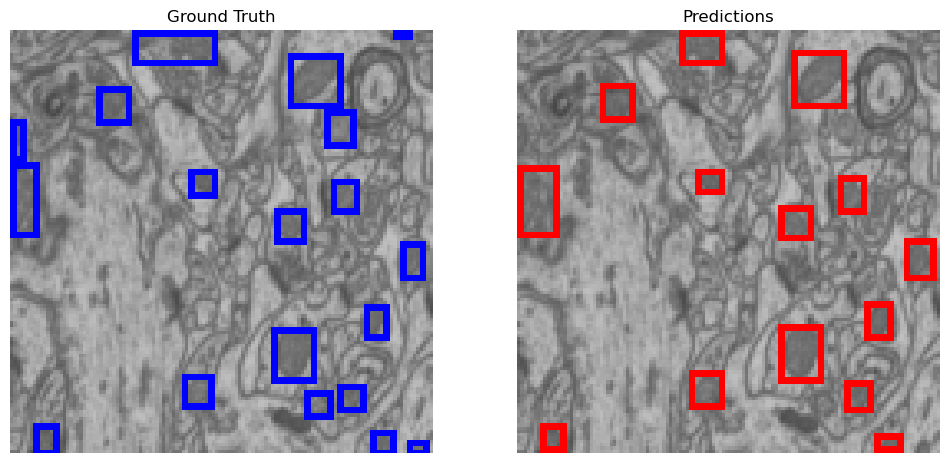

In [353]:
model_load_path = directory + 'fast_rcnn_densenet_model.pth'

model_densenet = load_model(model_densenet, model_load_path, device)

# Call the function to evaluate and plot predictions
evaluate_and_plot(model_densenet, val_loader, device, num_images=2)


In [238]:
pip install effdet

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.10.0 which is incompatible.


  Obtaining dependency information for effdet from https://files.pythonhosted.org/packages/9c/13/563119fe0af82aca5a3b89399c435953072c39515c2e818eb82793955c3b/effdet-0.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for timm>=0.9.2 from https://files.pythonhosted.org/packages/01/a5/eeb717242343d9ca34e7de554a6c08d96a0cfc7005ece4f847b1753581a6/timm-0.9.12-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
  Obtaining dependency information for pycocotools>=2.0.2 from https://files.pythonhosted.org/packages/24/b2/ef28a34cf6ca50b6b2f7ad81e5837ed45c252ffef22f5a704b94141ea842/pycocotools-2.0.7-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
     ---------------------------------------- 79.5/79.5 kB ? eta 0:00:00
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     ----

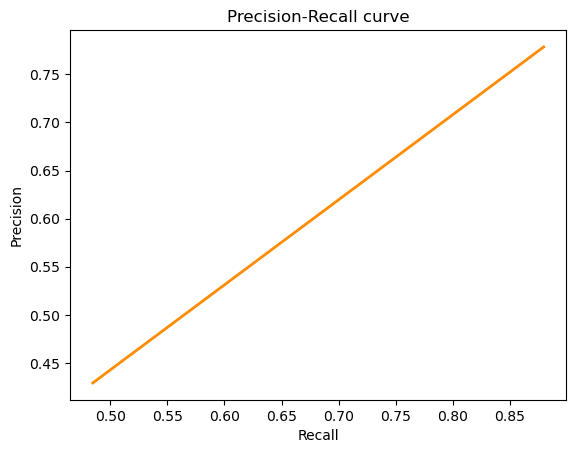

In [354]:
iou_thresholds = np.linspace(0.3, 0.8, 5)  # Example IoU thresholds
precisions2 = []
recalls2 = []

for iou_thresh in iou_thresholds:
    precision, recall, _ = evaluate_model(model_densenet, val_loader, device, iou_threshold=iou_thresh)
    precisions2.append(precision)
    recalls2.append(recall)

# Plotting Precision-Recall curve
plt.figure()
plt.plot(recalls2, precisions2, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()


In [355]:
from sklearn.metrics import auc
import numpy as np
from sklearn.metrics import precision_recall_curve

# Calculate the AP as the area under the PR curve
AP = auc(recalls2, precisions2)

# Find the best F1 score
f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions2, recalls2)]
max_f1_score = max(f1_scores)

print(f"Average Precision (AP): {AP}")
print(f"Best F1 Score: {max_f1_score}")


# Assuming `targets` and `predictions` are the ground truth and model output respectively
#precision, recall, thresholds = precision_recall_curve(targets, predictions)

# Find the index of the maximum precision
max_precision_index = np.argmax(precisions2)

# Get the maximum precision and corresponding recall
max_precision = precisions2[max_precision_index]
corresponding_recall = recalls2[max_precision_index]

print(f"Best Precision: {max_precision}")
print(f"Corresponding Recall: {corresponding_recall}")


Average Precision (AP): 0.2383558253314721
Best F1 Score: 0.825974025974026
Best Precision: 0.7785939139559287
Corresponding Recall: 0.8794942710391149


IoU Threshold: 0.2, Average IoU: 0.7459
IoU Threshold: 0.3, Average IoU: 0.7577
IoU Threshold: 0.4, Average IoU: 0.7733
IoU Threshold: 0.5, Average IoU: 0.7932
IoU Threshold: 0.6, Average IoU: 0.8067
IoU Threshold: 0.7, Average IoU: 0.8271
IoU Threshold: 0.8, Average IoU: 0.8629
IoU Threshold: 0.9, Average IoU: 0.9263


ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

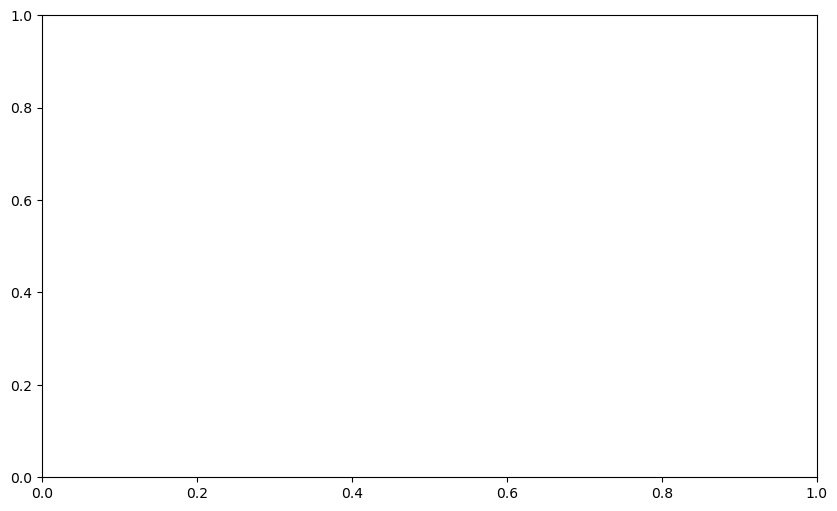

In [370]:
# Evaluate the model at different IoU thresholds
iou_thresholds = np.arange(0.2, 1.0, 0.1)  # From 0.2 to 0.9
iou_scores3 = []

for iou_thresh in iou_thresholds:
    average_iou = calculate_average_iou(model_densenet, val_loader, device, iou_threshold=iou_thresh)
    iou_scores.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.1f}, Average IoU: {average_iou:.4f}")


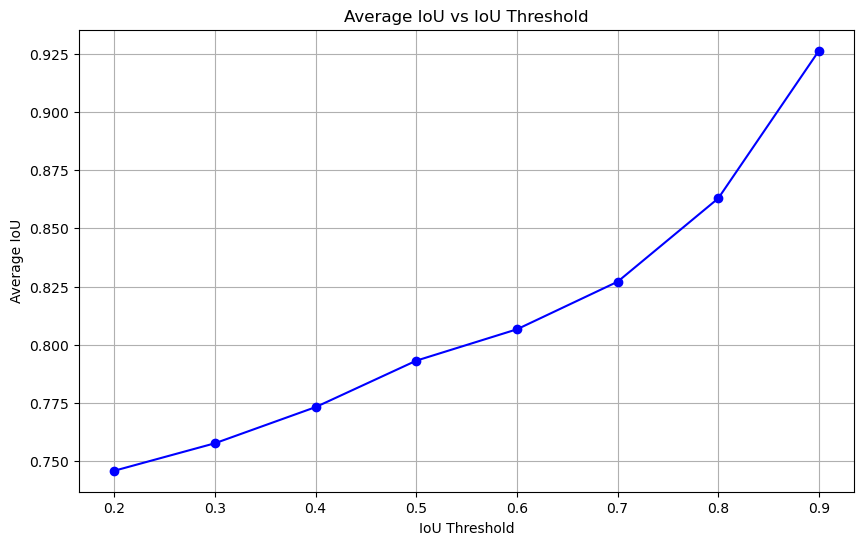

In [373]:
iou_scores3 = iou_scores[8:]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, iou_scores3, marker='o', color='b')
plt.title("Average IoU vs IoU Threshold")
plt.xlabel("IoU Threshold")
plt.ylabel("Average IoU")
plt.grid(True)
plt.show()

In [382]:

print(iou_thresholds)

iou_thresholds = np.arange(0.2, 1.0, 0.1)
additional_values = np.array([0.95, 0.99])

iou_thresholds = np.concatenate((iou_thresholds, additional_values))

print(iou_thresholds)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.95 0.99]


In [383]:
for iou_thresh in additional_values:
    average_iou = calculate_average_iou(model_densenet, val_loader, device, iou_threshold=iou_thresh)
    iou_scores.append(average_iou)
    print(f"IoU Threshold: {iou_thresh:.2f}, Average IoU: {average_iou:.4f}")

IoU Threshold: 0.9, Average IoU: 0.9600
IoU Threshold: 1.0, Average IoU: 0.0000
